# Load the model

In [31]:
try:
    model = tf.keras.models.load_model('model/model_1.keras')
    print("Model loaded successfully.")
except Exception as e:
    print("Error loading model: ", e)

Model loaded successfully.


# Record from the microphone

In [32]:
def record_audio_and_save(duration=2, sample_rate=16000, channels=1):
    # Record audio from microphone
    try:
        print("Recording...")
        audio_data = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=channels, dtype='int16')
        sd.wait()  
        print("Recording stopped.")
    except Exception as e:
        print("Error recording audio: ", e)

    # Generate a unique filename using current timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    file_path = f"recording/recorded_audio_{timestamp}.wav"

    # Check if the directory exists, if not create it
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    # Save the recorded audio to a file
    try:
        sf.write(file_path, audio_data, sample_rate)
        print(f"Audio saved as {file_path}")
    except Exception as e:
        print("Error saving audio file: ", e)

    return file_path


In [ ]:
def get_label_names():
    return ['ddyo', 'emabega', 'gaali', 'kkono', 'mumaaso', 'unknown', 'yimirira']

In [33]:
def get_mel_spectrogram(waveform, sample_rate=16000, n_mels=128):
    # Compute the Short-Time Fourier Transform (STFT)
    stft = tf.signal.stft(waveform, frame_length=255, frame_step=128)

    # Convert the magnitude of the STFT to a Mel spectrogram
    spectrogram = tf.abs(stft)
    mel_spectrogram = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=n_mels,
        num_spectrogram_bins=spectrogram.shape[-1],
        sample_rate=sample_rate
    )
    mel_spectrogram = tf.tensordot(spectrogram, mel_spectrogram, 1)
    mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)  # Log-scale

    # Add an axis for the batch size
    mel_spectrogram = mel_spectrogram[..., tf.newaxis]

    return mel_spectrogram


In [34]:
def record_and_predict():
    # Record audio and save it
    file_path = record_audio_and_save()

    # Load the audio file and preprocess for inference
    x = tf.io.read_file(str(file_path))
    x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
    x = tf.squeeze(x, axis=-1)
    waveform = x
    x = get_mel_spectrogram(x)
    x = x[np.newaxis, ..., np.newaxis]  # Add batch and channel dimensions
    print(x.shape)

    # Perform inference
    prediction = model.predict(x)

    # Get the labels
    label_names_slice = get_label_names()

    # Get the predicted label
    predicted_label_index = np.argmax(prediction[0])
    predicted_label = label_names_slice[predicted_label_index]

    # Display the prediction
    plt.bar(label_names_slice, tf.nn.softmax(prediction[0]))
    plt.title(predicted_label)
    plt.show()

    # Play the recorded audio
    return Audio(waveform, rate=16000)


Recording...
Recording stopped.
Audio saved as recording/recorded_audio_20240410_132858.wav
(1, 124, 128, 1, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


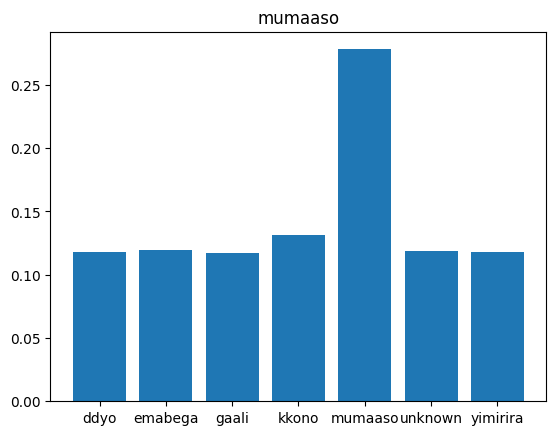

In [35]:
record_and_predict()